# Cell type deconvolution using MacSGP

In [14]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [15]:
RAW_PATH = "/import/home2/share/yqzeng/data/Mouth_brain_visium" # Raw data
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/Mouth_brain_visium" # Deconvolution results
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)

In [16]:
# scRNA-seq reference data

adata_ref = sc.read_h5ad(os.path.join(RAW_PATH, "reference/all_cells_20200625.h5ad"))
adata_ref.var.index = adata_ref.var["SYMBOL"].astype(str)
adata_ref.var_names_make_unique() # make gene names unique

labels = pd.read_csv(os.path.join(RAW_PATH, "reference/snRNA_annotation_astro_subtypes_refined59_20200823.csv"), index_col=0)
labels = labels.reindex(index=adata_ref.obs_names)

adata_ref.obs[labels.columns] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation_1'].isna(), :]
adata_ref.obs['celltype'] = adata_ref.obs['annotation_1']

## Visium Slice 1

In [37]:
# ST data

counts = pd.read_csv(os.path.join(RAW_PATH, "visium_1/mouse_brain_visium_1_counts.csv"), index_col=0)
coordinates = pd.read_csv(os.path.join(RAW_PATH, "visium_1/mouse_brain_visium_1_coordinates.csv"), index_col=0)

adata_st = ad.AnnData(X = counts.values)
adata_st.obs.index = counts.index
adata_st.var.index = counts.columns
adata_st.obsm['spatial'] = coordinates.values

adata_st.obs["array_row"] = coordinates.iloc[:, 0]
adata_st.obs["array_col"] = coordinates.iloc[:, 1]

In [38]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 26754 edges, 4168 spots.
6.4189059500959695 neighbors per spot on average.


In [39]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "celltype",
                                                n_hvg_group = 500)

Finding highly variable genes...
6415 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [44]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 16/10000 [00:00<02:13, 74.86it/s]

Step: 0, Loss: 4553.2075, d_loss: 4548.4702, f_loss: 47.3751


 10%|█         | 1016/10000 [00:13<01:59, 75.04it/s]

Step: 1000, Loss: -4463.3193, d_loss: -4465.4912, f_loss: 21.7178


 20%|██        | 2016/10000 [00:26<01:46, 74.95it/s]

Step: 2000, Loss: -5245.5239, d_loss: -5247.6504, f_loss: 21.2629


 30%|███       | 3016/10000 [00:40<01:33, 74.46it/s]

Step: 3000, Loss: -5593.0205, d_loss: -5595.1187, f_loss: 20.9800


 40%|████      | 4016/10000 [00:53<01:20, 74.36it/s]

Step: 4000, Loss: -5766.2642, d_loss: -5768.3350, f_loss: 20.7075


 50%|█████     | 5008/10000 [01:06<01:07, 74.15it/s]

Step: 5000, Loss: -5779.5312, d_loss: -5781.5894, f_loss: 20.5803


 60%|██████    | 6016/10000 [01:20<00:53, 74.33it/s]

Step: 6000, Loss: -5787.5859, d_loss: -5789.6304, f_loss: 20.4427


 70%|███████   | 7016/10000 [01:33<00:40, 74.33it/s]

Step: 7000, Loss: -5790.2544, d_loss: -5792.2915, f_loss: 20.3697


 80%|████████  | 8016/10000 [01:47<00:26, 74.42it/s]

Step: 8000, Loss: -5791.6187, d_loss: -5793.6484, f_loss: 20.3001


 90%|█████████ | 9016/10000 [02:00<00:13, 74.36it/s]

Step: 9000, Loss: -5791.5493, d_loss: -5793.5757, f_loss: 20.2634


100%|██████████| 10000/10000 [02:13<00:00, 74.80it/s]


In [46]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "visium_1.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "visium_1_basis.h5ad"))

Dropping cell types: ['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX', 'Astro_STR', 'Astro_THAL_hab', 'Astro_THAL_med', 'Astro_WM', 'Endo', 'Ext_Amy_1', 'Ext_Hpc_CA2', 'Ext_Hpc_DG2', 'Ext_L25', 'Ext_L5_3', 'Ext_Unk_1', 'Ext_Unk_2', 'Inh_5', 'Inh_6', 'Inh_Lamp5', 'Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_4', 'Inh_Vip', 'LowQ_1', 'LowQ_2', 'Micro', 'Nb_1', 'Nb_2', 'OPC_1', 'OPC_2', 'Unk_1', 'Unk_2']


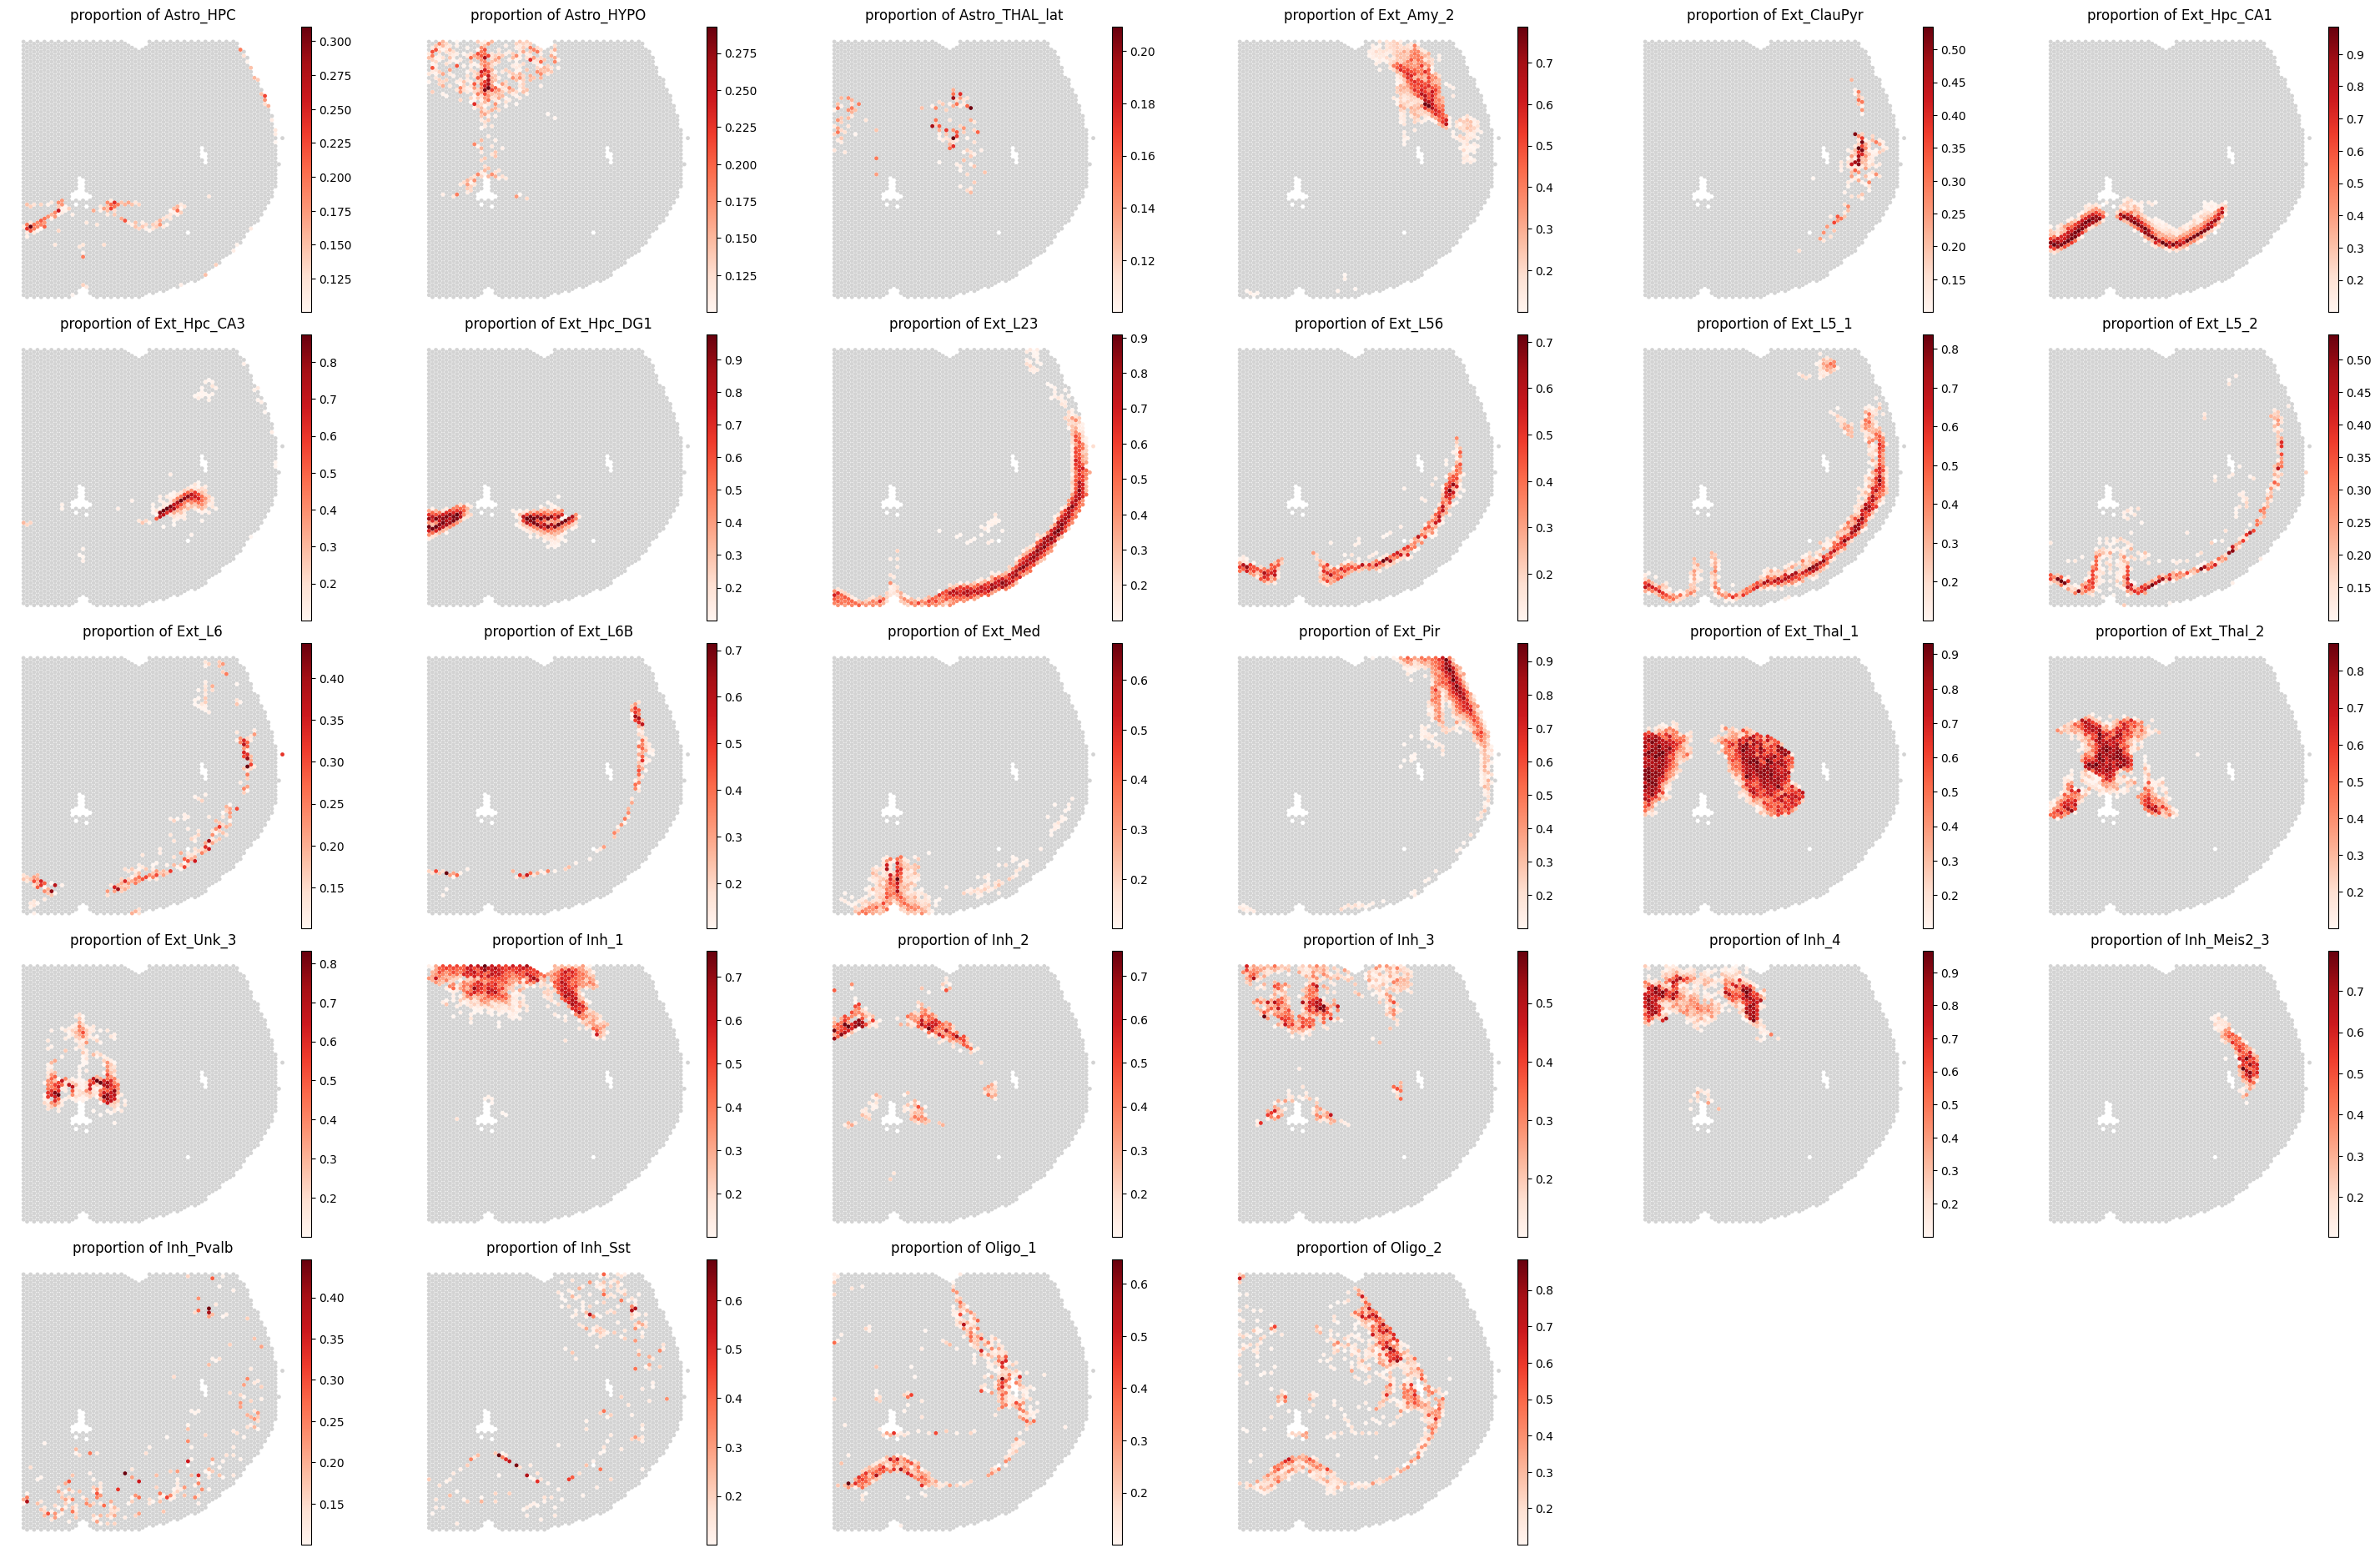

In [45]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion',
                proportion_threshold=0.1, num_threshold=100, 
                cmap='Reds', 
                spot_size=100, 
                ncols=6)

## Visium Slice 2

In [47]:
# ST data

counts = pd.read_csv(os.path.join(RAW_PATH, "visium_2/mouse_brain_visium_2_counts.csv"), index_col=0)
coordinates = pd.read_csv(os.path.join(RAW_PATH, "visium_2/mouse_brain_visium_2_coordinates.csv"), index_col=0)

adata_st = ad.AnnData(X = counts.values)
adata_st.obs.index = counts.index
adata_st.var.index = counts.columns
adata_st.obsm['spatial'] = coordinates.values

adata_st.obs["array_row"] = coordinates.iloc[:, 0]
adata_st.obs["array_col"] = coordinates.iloc[:, 1]

In [48]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 25789 edges, 3925 spots.
6.570445859872612 neighbors per spot on average.


In [49]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "celltype",
                                                n_hvg_group = 500)

Finding highly variable genes...
6415 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [50]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 8/10000 [00:00<02:20, 71.27it/s]

Step: 0, Loss: 4594.8994, d_loss: 4590.1553, f_loss: 47.4430


 10%|█         | 1008/10000 [00:13<02:02, 73.48it/s]

Step: 1000, Loss: -3777.2458, d_loss: -3779.5156, f_loss: 22.6986


 20%|██        | 2016/10000 [00:26<01:46, 74.75it/s]

Step: 2000, Loss: -4454.9248, d_loss: -4457.1533, f_loss: 22.2854


 30%|███       | 3016/10000 [00:40<01:33, 74.59it/s]

Step: 3000, Loss: -4782.7402, d_loss: -4784.9390, f_loss: 21.9869


 40%|████      | 4016/10000 [00:53<01:20, 74.43it/s]

Step: 4000, Loss: -4973.5015, d_loss: -4975.6694, f_loss: 21.6802


 50%|█████     | 5008/10000 [01:06<01:07, 74.21it/s]

Step: 5000, Loss: -5017.9502, d_loss: -5020.0986, f_loss: 21.4840


 60%|██████    | 6008/10000 [01:20<00:53, 74.16it/s]

Step: 6000, Loss: -5023.8066, d_loss: -5025.9424, f_loss: 21.3555


 70%|███████   | 7008/10000 [01:33<00:40, 74.15it/s]

Step: 7000, Loss: -5026.7617, d_loss: -5028.8872, f_loss: 21.2565


 80%|████████  | 8008/10000 [01:47<00:26, 74.18it/s]

Step: 8000, Loss: -5028.7729, d_loss: -5030.8975, f_loss: 21.2427


 90%|█████████ | 9008/10000 [02:00<00:13, 74.09it/s]

Step: 9000, Loss: -5030.3145, d_loss: -5032.4277, f_loss: 21.1305


100%|██████████| 10000/10000 [02:13<00:00, 74.77it/s]


In [53]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "visium_2.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "visium_2_basis.h5ad"))

Dropping cell types: ['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX', 'Astro_STR', 'Astro_THAL_hab', 'Astro_THAL_lat', 'Astro_THAL_med', 'Astro_WM', 'Endo', 'Ext_Amy_1', 'Ext_Hpc_CA2', 'Ext_Hpc_DG2', 'Ext_L5_3', 'Ext_Unk_1', 'Ext_Unk_2', 'Inh_5', 'Inh_6', 'Inh_Lamp5', 'Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_4', 'Inh_Vip', 'LowQ_1', 'LowQ_2', 'Micro', 'Nb_1', 'Nb_2', 'OPC_1', 'OPC_2', 'Unk_2']


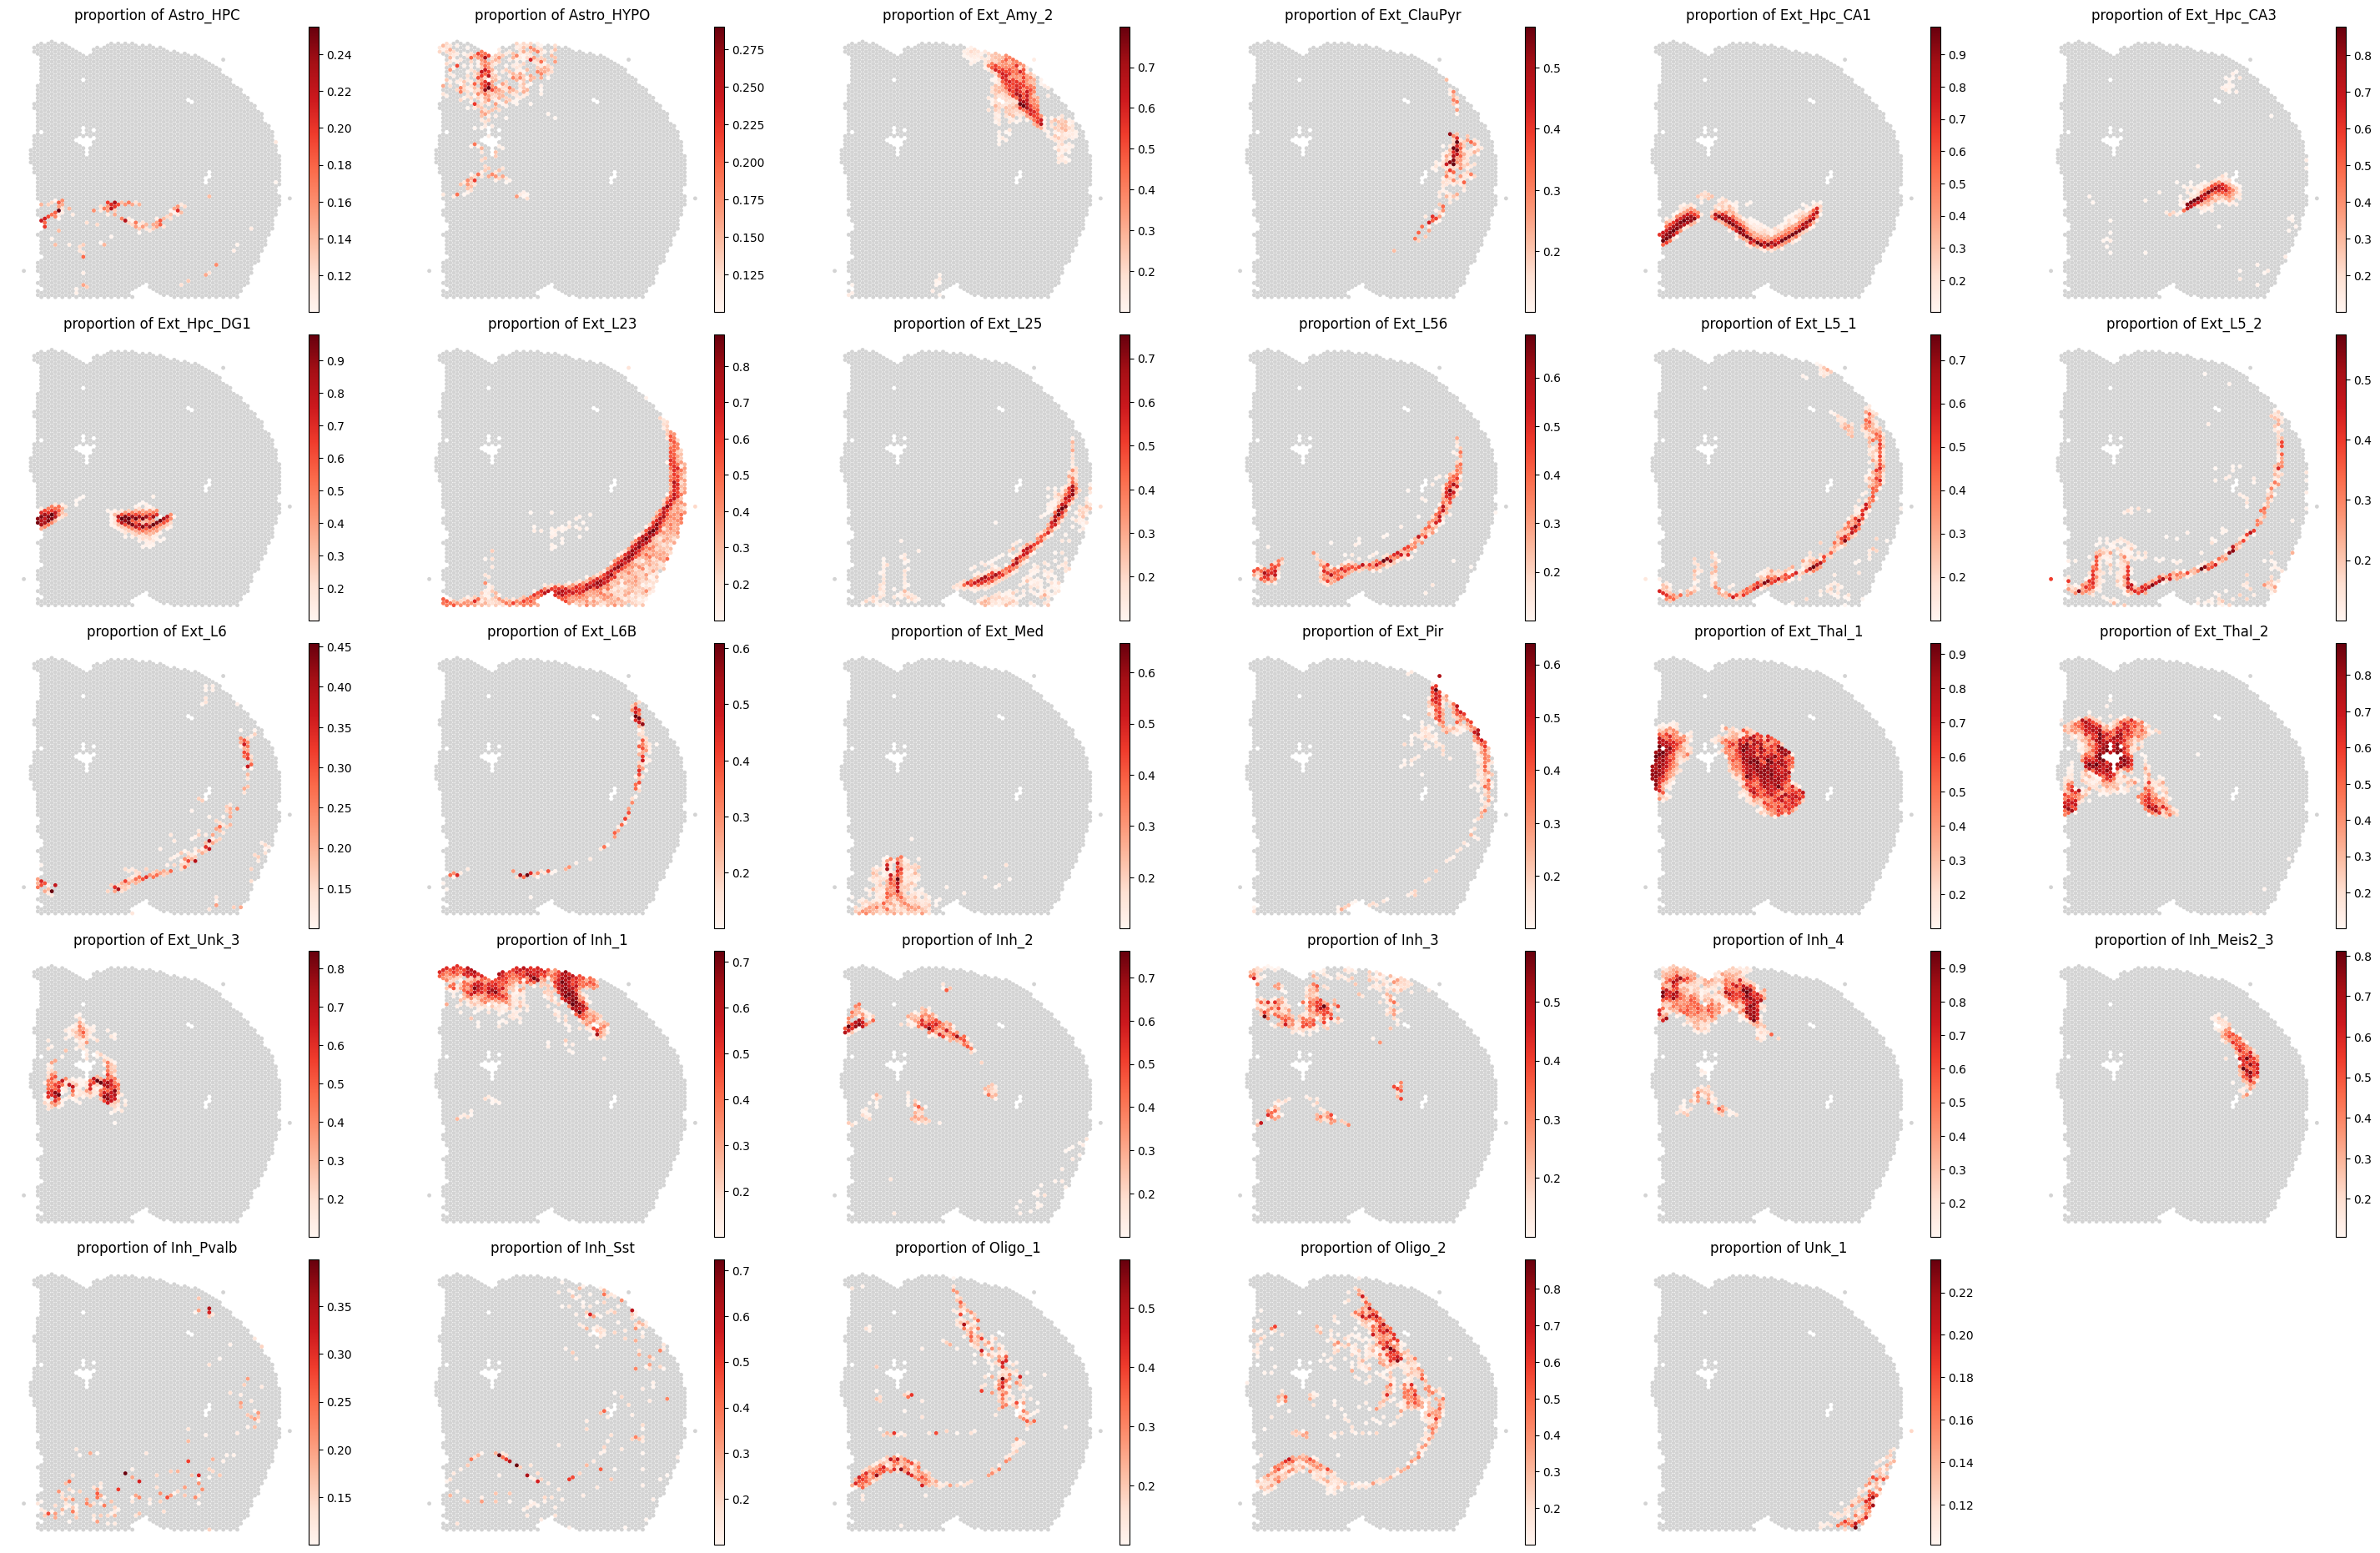

In [54]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion',
                proportion_threshold=0.1, num_threshold=100, 
                cmap='Reds', 
                spot_size=100, 
                ncols=6)